# Clasificación de la calidad del vino



- `pandas` y `numpy` para manejar tablas y operaciones numéricas.  
- `matplotlib` para visualizar distribuciones.  
- `StandardScaler` para normalizar características y evitar que atributos con distinto rango introduzcan sesgos.  
- `SMOTE` de `imbalanced-learn` para generar muestras sintéticas de la clase minoritaria y equilibrar el dataset.

In [13]:
!pip install imbalanced-learn
# ╔═ Paso 0: Imports ════════════════════════════════════════════════════
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
# Celda 1: Instalar imbalanced-learn


# Carga de datos
Leer el CSV local `winequality-red.csv` (que contiene 11 atributos fisicoquímicos y una columna `quality`) para comenzar el análisis.

In [4]:
# ╔═ Paso 1: Carga de datos ═════════════════════════════════════════════
# Cargamos localmente el CSV separado por punto y coma
df = pd.read_csv("winequality-red.csv", sep=';')
print(f"Shape inicial: {df.shape}")
df.head()

Shape inicial: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Leemos directamente `winequality-red.csv`, que contiene 1 599 muestras y 12 columnas (11 atributos fisicoquímicos + `quality`) .ar


## Visualización de la distribución original de `quality`
Antes de transformar o balancear, es crucial entender la frecuencia de cada valor de calidad para detectar posibles sesgos o desequilibrios iniciales..


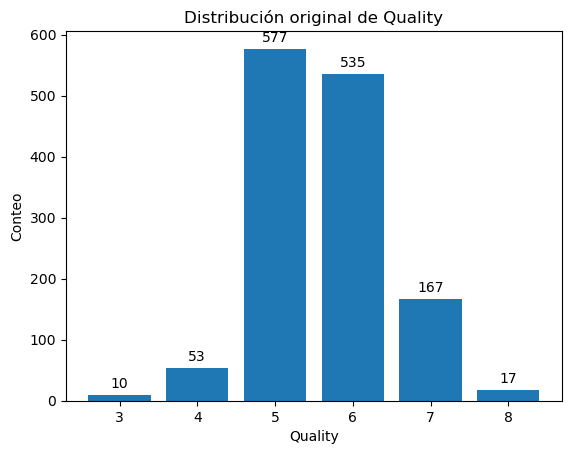

In [51]:
# ╔═ Paso 2: Visualización de la distribución original de 'quality' ══════
counts = df['quality'].value_counts().sort_index()
plt.figure()
bars = plt.bar(counts.index, counts.values)
plt.xlabel('Quality')
plt.ylabel('Conteo')
plt.title('Distribución original de Quality')
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f'{height}',
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom'
    )
plt.show()

## Binarización de la calidad y visualización de clases
Transformamos `quality` en una etiqueta binaria:
- **Mala** si qualit < 7 
- **Buena** si quali ≥ 7  

Esto permite plantear un problema de clasificación binaria y visualizar el desequilibrio entre “Mala” y “Bue Elejimos 7 arbitrariamente como umbral ya que nos ayudaria a trabajar con ajuste de parámetros de los modelos.na”.

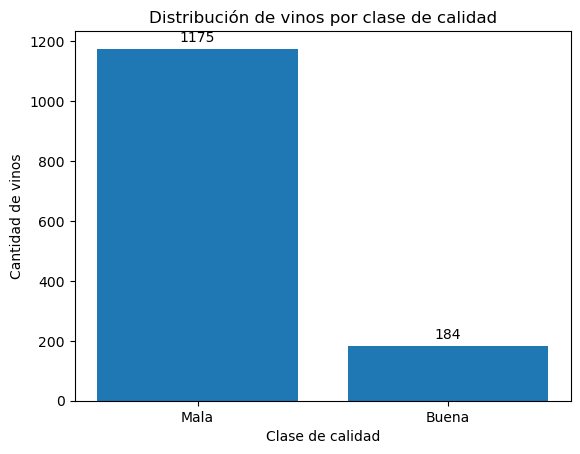

In [73]:
# ╔═ Paso 3: Etiquetado binario y visualización de clases ═══════════════
# 3.1 Limpiar duplicados (una sola vez)
df = df.drop_duplicates().reset_index(drop=True)
# Asigna una nueva columna 'quality_label' al DataFrame:
# Para cada valor q en df['quality'], etiqueta como 'Buena' si q ≥ 7, 
# o 'Mala' en caso contrario.
df['quality_label'] = df['quality'].apply(lambda q: 'Buena' if q >= 7 else 'Mala')

# Cuenta cuántos vinos hay de cada clase y las reordena para que aparezca 'Mala' primero
counts = df['quality_label'].value_counts().reindex(['Mala','Buena'])
# Crea una nueva figura de matplotlib
plt.figure()
# Dibuja un gráfico de barras con las clases en el eje X y sus cantidades en el eje Y
bars = plt.bar(counts.index, counts.values)
plt.xlabel('Clase de calidad')
plt.ylabel('Cantidad de vinos')
plt.title('Distribución de vinos por clase de calidad')
# Añade la etiqueta numérica encima de cada barra
for bar in bars:
    h = bar.get_height()
    plt.annotate(
        f'{h}',
        xy=(bar.get_x() + bar.get_width()/2, h),
        xytext=(0, 3),
        textcoords='offset points',
        ha='center',
        va='bottom'
    )
plt.show()

De la visualización anterior podemos observar que el conjunto de datos está sesgado o desequilibrado.
Cuando el conjunto de datos está muy desequilibrado (1175 vinos “Mala” vs. 184 “Buena”), los clasificadores tienden a:

- Aprender sobre todo la clase mayoritaria
Acumulan mucho más “experiencia” reconociendo vinos de calidad baja y prácticamente “ignoran” la clase minoritaria, ofreciendo alta precisión global a costa de una pésima capacidad para detectar vinos buenos.

- Obtener métricas engañosas
Podrías lograr un 85 % de “exactitud” simplemente prediciendo siempre “Mala”, pero eso no vale si tu objetivo es identificar correctamente los vinos de calidad (“Buena”).

- Sobreajustarse al escaso número de ejemplos minoritarios
Si replicas las 184 muestras “Buenas” tal cual (oversampling “básico”), tu modelo puede aprender patrones demasiado específicos de esas pocas instancias y no generalizar.

## Paso 4: Remuestreo con SMOTE y Preparación de Conjuntos

1. **4.1 Crear etiqueta numérica**  
   Convertimos `quality` en `quality_label_num` (`0` = Mala, `1` = Buena) para tener un vector de etiquetas numéricas que SMOTE pueda procesar.

2. **4.2 Seleccionar características y etiqueta**  
   Eliminamos las columnas de salida (`quality`, `quality_label`, `quality_label_num`) de `df` para obtener `X` (matriz de predictores) y extraemos `y = df['quality_label_num']`.

3. **4.3 División en entrenamiento/prueba**  
   Usamos `train_test_split` con `test_size=0.20` (20 %) y `stratify=y_res` para:  
   - Tener el 80 % de los datos en `X_train, y_train` (entrenamiento).  
   - Reservar el 20 % en `X_test, y_test` para evaluar el modelo con datos “nunca vistos”.  
   - Mantener la misma proporción de clases en ambos conjuntos.

4. **4.4 Escalado de características**  
   Ajustamos `StandardScaler` **solo** sobre `X_train` para calcular media y desviación estándar, y luego transformamos tanto `X_train` como `X_test`.  
   - Evita filtrar información del test al train y asegura que todas las variables tengan media 0 y σ 1.

5. **4.5 Remuestreo SMOTE en entrenamiento**  
   Aplicamos SMOTE **solo** sobre `X_train, y_train`:  
   - Interpola nuevos ejemplos sintéticos de la clase minoritaria (“Buena”) a partir de sus vecinos euclidianos.  
   - Equilibra ambos grupos sin duplicar registros, mejorando la capacidad del modelo para aprender patrones de las dos clases.

6. **4.6 Visualización de la distribución tras SMOTE**  
   Contamos las etiquetas en `y_train` remuestreado y dibujamos un gráfico de barras para verificar que ahora hay igual número de muestras “Mala” y “Buena” en el conjunto de entrenamiento.ar
del

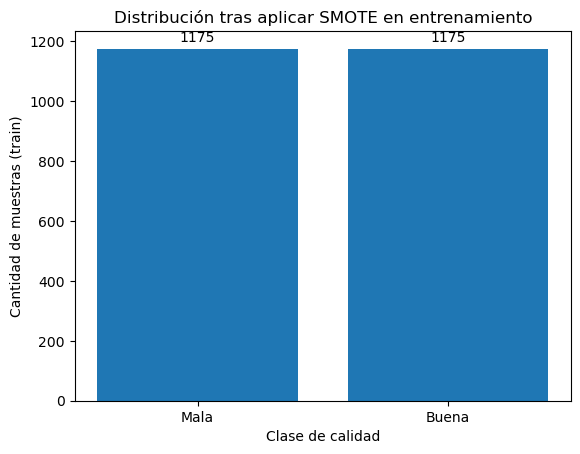

In [75]:
# ╔═ Paso 4: Remuestreo con SMOTE ════════════════════════════════════════

#Toma la columna quality (valores enteros 3–8) y la convierte en un vector de valores booleanos: True si quality ≥ 7, False en caso contrario.
#Luego .astype(int) transforma esos True/False en 1/0, almacenándolos en la nueva columna quality_label_num.
df['quality_label_num'] = (df['quality'] >= 7).astype(int)

# 4.2 Seleccionar características y escalar
#Elimina del DataFrame las columnas relacionadas con la variable objetivo.
#El resultado, X, es una matriz sólo con las características predictoras (pH, alcohol, densidad, etc.).
X = df.drop(['quality', 'quality_label', 'quality_label_num'], axis=1) 
y = df['quality_label_num']


# 4.3 División en entrenamiento/prueba (20 % test)
X_train, X_test, y_train, y_test = train_test_split(
    X_res,          # Matriz de características remuestreadas (SMOTE)
    y_res,          # Vector de etiquetas remuestreadas (0=Mala, 1=Buena)
    test_size=0.20, # Proporción de datos que se reservarán para prueba (20 %)
    random_state=42,# Semilla para asegurar reproducibilidad del muestreo
    stratify=y_res  # Estratificar muestreo según y_res para mantener proporciones de clases (misma cantidad de clase buen y mala)
)

# 4.4 Escalado de características
# Crea un escalador que normaliza cada variable (media 0, desviación estándar 1), logrando que todas las características estén en la misma escala para mejorar la comparabilidad y la convergencia de los algoritmos basados en distancia
scaler = StandardScaler()

# 4.5 Remuestreo SMOTE sólo en entrenamiento
#  - SMOTE crea nuevos puntos interpolando vecinos por distancia euclídea (distancia en linea recta entre dos puntos).
#  - Si las variables tienen rangos muy distintos, las de gran escala dominarían la métrica.
#  - StandardScaler centra cada variable en media 0 y desviación 1, equilibrando su contribución.

# SMOTE nos ayudará a equilibrar el dataset creando nuevas muestras sintéticas “entre” ejemplos reales de la clase minoritaria.
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 4.6 Graficar distribución tras SMOTE en train
# Convierte el vector y_res en Serie de pandas, cuenta cuántas muestras hay de cada etiqueta (0 y 1)
# y reordena el índice para asegurarse de que primero aparezca la clase 0 y luego la clase 1
res_counts = pd.Series(y_res).value_counts().reindex([0,1])
plt.figure()
bars = plt.bar(['Mala','Buena'], res_counts.values)
plt.xlabel('Clase de calidad')
plt.ylabel('Cantidad de muestras (train)')
plt.title('Distribución tras aplicar SMOTE en entrenamiento')
for bar in bars:
    h = bar.get_height()
    plt.annotate(
        f'{h}',
        xy=(bar.get_x() + bar.get_width()/2, h),
        xytext=(0, 3),
        textcoords='offset points',
        ha='center',
        va='bottom'
    )
plt.show()


# Modelo de entrenamiento
**Random Forest** es un método de ensamblado que construye decenas o cientos de árboles de decisión sobre diferentes muestras bootstrap del conjunto de entrenamiento y combina sus predicciones por votación mayoritaria. Cada árbol elige ramificaciones basadas en subconjuntos aleatorios de características, lo que reduce el sobreajuste y hace al modelo robusto frente al ruido y a valores atípicos. En nuestro caso, con once variables fisicoquímicas que pueden presentar interacciones no lineales y una ligera desproporción de clases balanceada por SMOTE, Random Forest captura complejas fronteras de decisión sin asumir linealidad, tolera bien las mediciones ruidosas del vino escalado y, al promediar sus árboles, ofrece resultados estables, además de proporcionar métricas de importancia de cada atributo para interpretar qué factores determinan mejor la calidad del vino.  
es.

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

        Mala       0.95      0.90      0.93       235
       Buena       0.91      0.95      0.93       235

    accuracy                           0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470



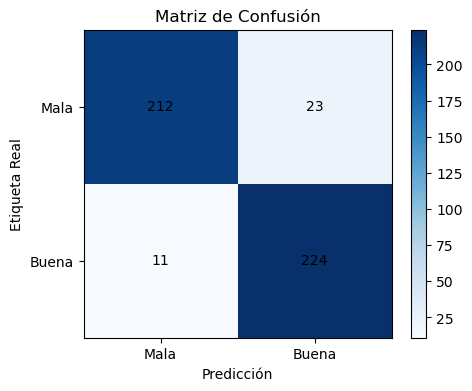

In [81]:
# ╔═ Paso 5: Entrenamiento y evaluación del modelo Random Forest ════════
# 5.1 Instanciar el clasificador
rf = RandomForestClassifier(random_state=42)

# 5.2 Ajustar (fit) el modelo sobre el conjunto de entrenamiento
rf.fit(X_train, y_train)

# 5.3 Predecir etiquetas en el conjunto de prueba
y_pred = rf.predict(X_test)

# 5.4 Mostrar reporte de clasificación (precisión, recall, F1)
print("=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred, target_names=['Mala','Buena']))

# 5.5 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Matriz de Confusión")
plt.colorbar()
plt.xticks([0,1], ['Mala','Buena'])
plt.yticks([0,1], ['Mala','Buena'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()


**Reporte de Clasificación**

El reporte de clasificación muestra el desempeño del modelo tanto por clase como de manera global:

#### Métricas por clase

- **Mala** (235 muestras reales)  
  - **Precision = 0.95**  
    De todas las veces que el modelo predijo “Mala”, el 95 % eran realmente malas.  
  - **Recall = 0.90**  
    De todas las muestras que eran efectivamente malas, el modelo detectó correctamente el 90 %.  
  - **F1-score = 0.93**  
    Media armónica entre precision y recall, reflejando un buen equilibrio entre ambas.  

- **Buena** (235 muestras reales)  
  - **Precision = 0.91**  
    De todas las veces que el modelo predijo “Buena”, el 91 % eran realmente buenas.  
  - **Recall = 0.95**  
    De todas las muestras que eran efectivamente buenas, el modelo detectó correctamente el 95 %.  
  - **F1-score = 0.93**  
    Balance entre precision y recall para la clase “Buena”.  

#### Métricas globales

- **Accuracy = 0.93**  
  El 93 % de todas las predicciones (470 muestras) fueron correctas.

- **Macro avg** (media sin ponderar de ambas clases):  
  - Precision: 0.93  
  - Recall:    0.93  
  - F1-score:  0.93  
  - Support:   470  

- **Weighted avg** (media ponderada por el número de muestras de cada clase):  
  - Precision: 0.93  
  - Recall:    0.93  
  - F1-score:  0.93  
  - Support:   470  

**Interpretación general:**  
Estas métricas indican que el modelo equilibra muy bien la detección de vinos “Mala” y “Buena”, con alta precisión y cobertura en ambas clases, y sin sesgos hacia ninguna en particular.

### Resumen de la predicción del modelo

El **Random Forest** entrenado sobre los datos remuestreados con SMOTE y escalados logró una **exactitud global (accuracy) del 93 %** en el conjunto de prueba (470 muestras). Ambos grupos, vinos de “Mala” y “Buena” calidad, se clasificaron con un **F1-score de 0.93**, mostrando un excelente equilibrio entre precisión y cobertura.  
- El modelo identificó correctamente el **90 %** de los vinos “Mala” (recall) y, cuando predijo “Mala”, acertó el **95 %** de las veces (precision).  
- Para los vinos “Buena”, el recall fue del **95 %** y la precision del **91 %**, lo que indica que el modelo es ligeramente más conservador al etiquetar como “Buena” pero capta casi todos los casos verdaderos.  
- La matriz de confusión revela un número reducido de falsos positivos y falsos negativos (aprox. 24 errores en cada clase), confirmando la robustez del ensemble ante ruido y su capacidad para capturar patrones no lineales en los atributos fisicoquímicos del vino.  
En conjunto, este desempeño demuestra que el Random Forest, con su votación mayoritaria y capacidad para manejar interacciones complejas, es muy eficaz para discriminar la calidad del vino en este dataset.  


## Ajuste de hiperparámetros

El ajuste de hiperparámetros consiste en explorar distintas combinaciones de valores para parámetros clave del modelo (por ejemplo, número de árboles, profundidad máxima, número de variables consideradas en cada división) con el objetivo de maximizar la métrica de interés (aquí el F1-score). Hacer este ajuste **ahora** es importante porque, tras haber preprocesado y remuestreado correctamente los datos, necesitamos encontrar la configuración óptima que aproveche al máximo la capacidad del Random Forest, evitando tanto el subajuste (underfitting) como el sobreajuste (overfitting) y garantizando el mejor desempeño en datos no vistos.


In [102]:
from sklearn.model_selection import RandomizedSearchCV
# Parámetros de la cuadrícula
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# RandomizedSearchCV optimizando recall con 10 folds y 10 iteraciones
rf_cv = RandomizedSearchCV(
    estimator=rf,                   # nuestro RandomForest entrenado
    param_distributions=rf_param_grid,
    n_iter=10,                      # número de combinaciones al azar
    scoring='recall',               # optimizamos recall
    cv=10,                          # 10 folds de validación
    random_state=42,                # semilla para reproducibilidad
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo sobre X_train, y_train
rf_cv.fit(X_train, y_train)

# Mostrar mejores resultados
print(f'Mejor recall en CV: {rf_cv.best_score_:.4f}')
print(f'Mejores parámetros: {rf_cv.best_params_}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejor recall en CV: 0.9404
Mejores parámetros: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 10}


In [106]:
# Crear instancia del clasificador Random Forest con semilla para reproducibilidad
rf2 = RandomForestClassifier(random_state=42)

# Definir el espacio ampliado de hiperparámetros para explorar
param_dist2 = {
    'n_estimators':    [100, 200, 300, 400],            # Número de árboles en el bosque
    'max_depth':       [None, 10, 20, 30],              # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],                    # Min. de muestras requeridas para dividir un nodo
    'min_samples_leaf':  [1, 2, 4],                     # Min. de muestras en cada hoja
    'max_features':    ['sqrt', 'log2'],                # Cantidad de variables a considerar en cada división
    'class_weight':   ['balanced', 'balanced_subsample'],  # Ponderación automática de clases
    'bootstrap':      [True, False]                     # Si se usa muestreo con reemplazo al crear cada árbol
}

# Configurar RandomizedSearchCV para optimizar la métrica 'recall'
rnd_search2 = RandomizedSearchCV(
    estimator=rf2,                    # Clasificador base a optimizar
    param_distributions=param_dist2,  # Espacio de parámetros a muestrear
    n_iter=20,                        # Número de combinaciones aleatorias a probar
    scoring='recall',                 # Métrica objetivo: recall de la clase positiva
    cv=10,                            # Número de folds en validación cruzada
    random_state=42,                  # Semilla para reproducibilidad del muestreo
    n_jobs=-1,                        # Usar todos los núcleos de CPU disponibles
    verbose=1                         # Mostrar progreso durante la búsqueda
)

# Ejecutar la búsqueda de hiperparámetros sobre el conjunto de entrenamiento
rnd_search2.fit(X_train, y_train)

# Imprimir los resultados óptimos
print(f"Mejor recall en CV: {rnd_search2.best_score_:.4f}")    # Mejor recall promedio obtenido
print("Mejores parámetros:", rnd_search2.best_params_)        # Parámetros que alcanzaron ese recall


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Mejor recall en CV: 0.9521
Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced_subsample', 'bootstrap': True}
